In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from itertools import combinations

intreday_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\intraday\\omega"
daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega"

intraday_mstock = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\intraday\\mstock"
daily_mstock = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\mstock"

def get_dataframes(data_dir):
    dataframes = dict()
    #dataframes = []
    for filename in os.listdir(data_dir):
        path = os.path.join(data_dir, filename)
        df = pd.read_csv(path, delimiter=',', header=0, parse_dates=['Date'])
        dataframes[filename.replace('.prn', '')] = df
        #dataframes.append(df)
    return dataframes

# Data examination and selction

### specifying years of interest, merging data from different companies

In [2]:
N = 10
threshold = 0.683 *N *365
time_delta = pd.Timedelta(days=365*N)
end_date = pd.to_datetime('2024-06-20')
start_date = end_date - time_delta

dataframes_dict = get_dataframes(daily_omega)
dataframes = list(dataframes_dict.values())

# 10 lat: 224
dataframes_tuple = [(df.rename(columns={"Close": name})[df['Date']>=start_date], name) for name, df in dataframes_dict.items()] 
dataframes_tuple = [(df, name) for df, name in dataframes_tuple if len(df)>threshold]

merged_df = dataframes_tuple[0][0]
for df, _ in dataframes_tuple[1:]:
    merged_df = pd.merge(merged_df, df, on='Date', how='outer')

In [3]:
print(f'{len(merged_df)} time stamps and {len(merged_df.dropna())} full time stamps')

companies = merged_df.columns[1:]

print(f'Number of companies: {len(companies)}')
print(companies)


2499 time stamps and 2473 full time stamps
Number of companies: 35
Index(['11BIT', 'ABPL', 'ACTION', 'AGORA', 'ALIOR', 'AMICA', 'AMREST', 'ASBIS',
       'ASSECOPOL', 'BIOTON', 'BLOOBER', 'BOGDANKA', 'BORYSZEW', 'BOS',
       'BUDIMEX', 'CCC', 'CDPROJEKT', 'CIGAMES', 'COMARCH', 'CORMAY',
       'CYFRPLSAT', 'DOMDEV', 'ECHO', 'ENEA', 'ENERGA', 'ETFSP500', 'EUROCASH',
       'FARM51', 'FERRO', 'FORTE', 'GPW', 'GRUPAAZOTY', 'ORANGEPL', 'PGE',
       'PKPCARGO'],
      dtype='object')


### selecting companies present in GICS classification file

In [4]:
class_file = r"C:\\physics_masters\\data\\GICS_classification.csv"

class_df = pd.read_csv(class_file, delimiter=',', header=None, skipinitialspace=True, usecols=[0, 1, 2, 3])
selected_companies_df = class_df[class_df[1].isin(companies)]

print(f'final number of companies: {len(selected_companies_df)}')

merged_df = merged_df[np.append(['Date'], selected_companies_df[1])]
print(f'{len(merged_df)} time stamps and {len(merged_df.dropna())} full time stamps')

selected_companies_df = selected_companies_df.rename(columns={0: 'Company', 1: 'Name', 2: 'Sector', 3: 'Subsector'})
selected_companies_df

final number of companies: 22
2499 time stamps and 2484 full time stamps


,Company,Name,Sector,Subsector
11,CD Projekt SA,CDPROJEKT,Communication Services,Media & Entertainment
13,PGE Polska Grupa Energetyczna SA,PGE,Utilities,Utilities
14,CCC SA,CCC,Consumer Discretionary,Retailing
17,Alior Bank SA,ALIOR,Financials,Banks
18,Budimex SA,BUDIMEX,Industrials,Capital Goods
20,Asseco Poland SA,ASSECOPOL,Information Technology,Software & Services
21,Orange Polska SA,ORANGEPL,Communication Services,Telecommunication Services
22,Cyfrowy Polsat SA,CYFRPLSAT,Communication Services,Telecommunication Services
27,ENEA SA,ENEA,Utilities,Utilities
30,Dom Development SA,DOMDEV,Real Estate,Real Estate


In [5]:
selected_companies_df.groupby('Sector').count()[['Company']]

,Company
Sector,
Communication Services,3
Consumer Discretionary,2
Consumer Staples,1
Energy,1
Financials,3
Industrials,4
Information Technology,2
Materials,1
Real Estate,2


In [64]:
# pominięte - nie było w csv gics
companies.difference(class_df[1])

Index(['11BIT', 'ACTION', 'AGORA', 'AMICA', 'ASBIS', 'BIOTON', 'BLOOBER',
       'CIGAMES', 'COMARCH', 'CORMAY', 'ETFSP500', 'FARM51', 'FORTE'],
      dtype='object')

# Data abberations

### Example: AMREST
stock split in 2018

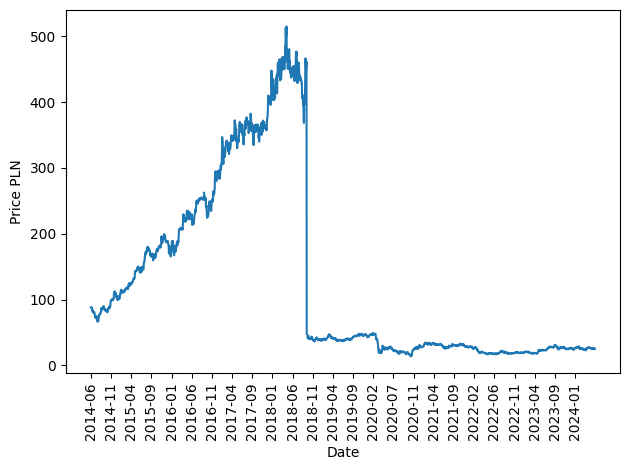

In [44]:
plt.plot(merged_df['AMREST'])
plt.xticks(range(0, len(merged_df), 100), merged_df['Date'][::100].dt.strftime('%Y-%m'), rotation=90)
plt.xlabel('Date')
plt.ylabel('Price PLN')
plt.tight_layout()


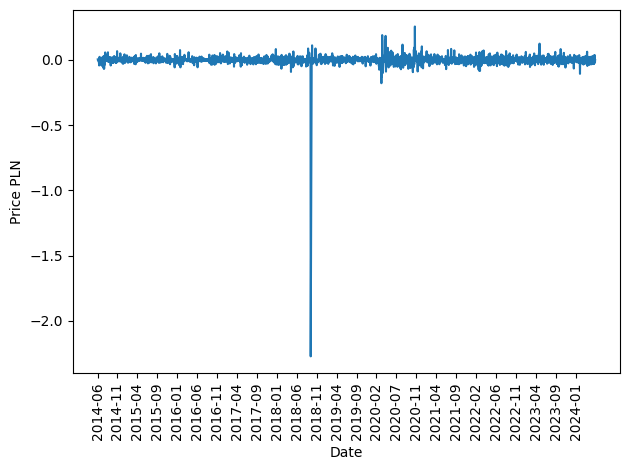

In [46]:
plt.plot(np.log(merged_df['AMREST']).diff().dropna())
plt.xticks(range(0, len(merged_df), 100), merged_df['Date'][::100].dt.strftime('%Y-%m'), rotation=90)
plt.xlabel('Date')
plt.ylabel('Price PLN')
plt.tight_layout()

In [61]:
logreturns = np.log(merged_df[selected_companies_df['Name']].ffill().dropna()).diff().dropna()
logreturns['AMREST'].quantile(0.995)


np.float64(0.08671561134829853)

# Stationary correlations

### calculate log returns

In [75]:
m_df = merged_df.copy()
m_df = m_df.ffill() # only several na's to be removed - fill in with previous values

for name in m_df.columns[1:]:
    m_df[name+'_Close'] = m_df[name]
    m_df[name+'_logClose'] =np.log(m_df[name])
    diff = m_df[name+'_logClose'].diff()
    m_df[name+'_DifflogClose'] = diff
    
    q_low = diff.dropna().quantile(0.005)
    q_hi  = diff.dropna().quantile(0.995)

    m_df.loc[(m_df[name+'_DifflogClose'] > q_hi) | (m_df[name+'_DifflogClose'] < q_low), name+'_DifflogClose'] = np.nan


m_df = m_df.dropna() #remove first row and outliers

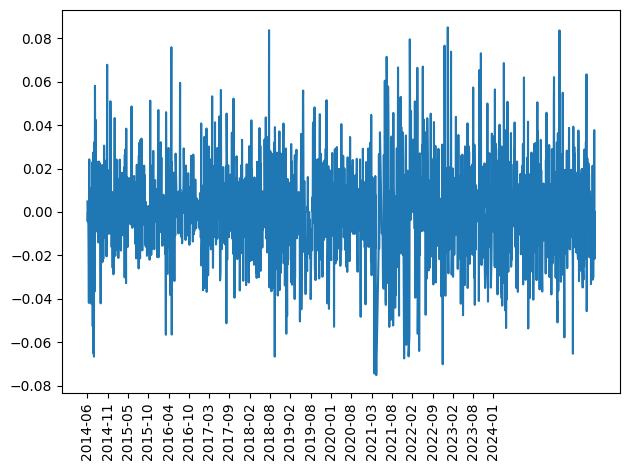

In [79]:
#check result for AMREST
plt.plot(m_df['AMREST_DifflogClose'])
plt.xticks(range(0, len(m_df), 100), m_df['Date'][::100].dt.strftime('%Y-%m'), rotation=90)
plt.tight_layout()

In [80]:
difflogcols = [col for col in m_df.columns if 'DifflogClose' in col]

def I0(t):
    return np.mean(m_df.iloc[t][difflogcols])

def D(tau):
    t_start = tau
    t_end = len(m_df)
    denominator = np.mean([I0(t)**2 for t in range(t_start, t_end)])
    
    matrix = m_df.iloc[t_start:t_end][difflogcols].to_numpy()
    I0s_disp = np.array([I0(t) for t in range(0, t_end - tau)])

    numerator = (matrix.T*I0s_disp) @ matrix / matrix.shape[0]
    
    return numerator/denominator


In [81]:
from ipywidgets import interact, IntSlider

# Your D(tau) must already be defined
# And m_df + difflogcols available in scope

@interact(tau=IntSlider(min=1, max=500, step=100, value=1, description='τ'))
def plot_D_tau(tau):
    D_tau = D(tau)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(D_tau, cmap="coolwarm", center=0, 
                xticklabels=difflogcols, yticklabels=difflogcols, square=True)
    plt.title(f"D(τ={tau})")
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=1, description='τ', max=500, min=1, step=100), Output()), _dom_classes=(…

In [154]:
R = m_df[difflogcols].to_numpy()

C = R.T@R / R.shape[0]



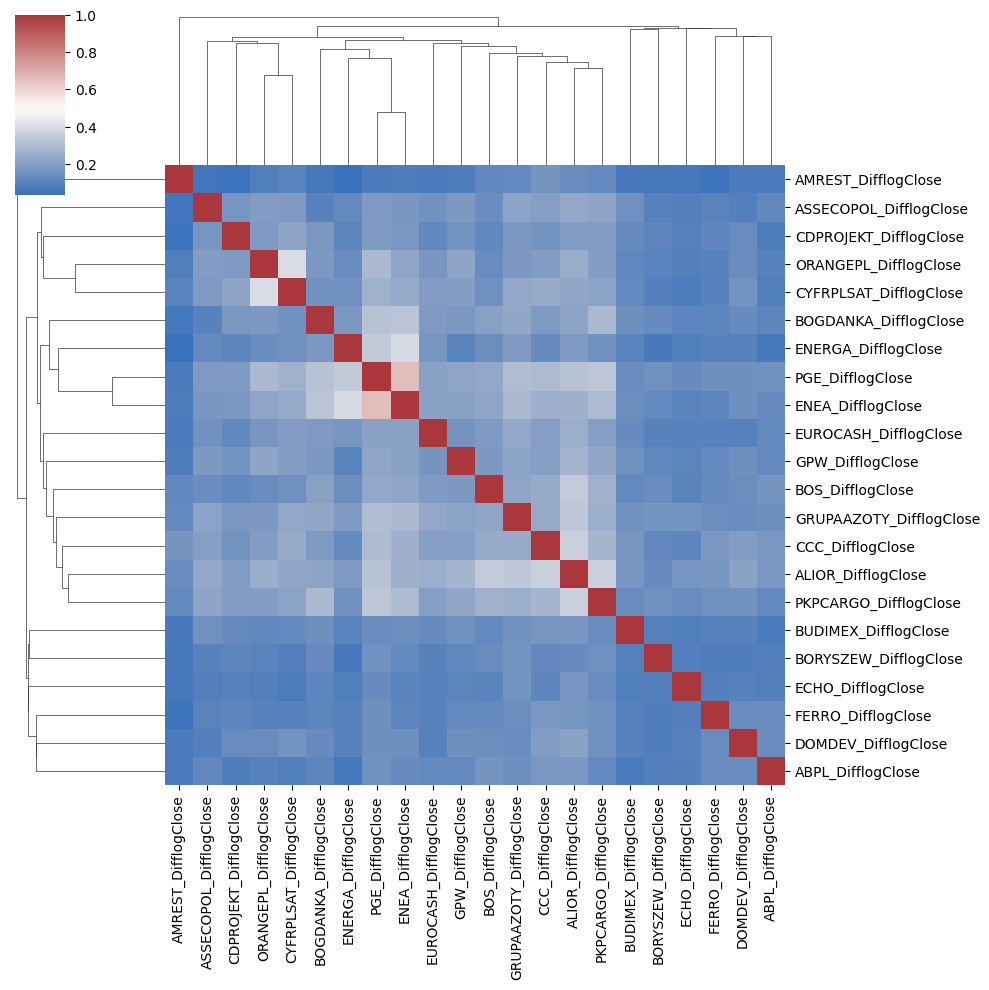

In [131]:
difflogcols = [col for col in m_df.columns if 'DifflogClose' in col]

corr = m_df[difflogcols].corr(method='pearson')


res = sns.clustermap(corr, cmap="vlag", center=0.5)


In [ ]:
import scipy.cluster


Z = res.dendrogram_row.linkage  # or cg.dendrogram_col.linkage if you're clustering columns


# Total number of items
n_items = Z.shape[0] + 1

# You want the state of clustering after 3 merges => n - 3 clusters
n_clusters = 4

# Get cluster labels
labels = scipy.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')

In [124]:
Z = res.dendrogram_row.linkage
row_labels = res.data.index.to_list()  # or columns if dendrogram_col

# Step 2: Get clusters at level = 3 merges deep
n_items = Z.shape[0] + 1
n_clusters = 10  # after 3 merges, this many clusters remain
cluster_ids = scipy.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')

# Step 3: Map back to row labels
label_cluster_map = pd.Series(cluster_ids, index=row_labels)

# If you want to group them:
for cluster_id in sorted(label_cluster_map.unique()):
    members = label_cluster_map[label_cluster_map == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: {members}")

Cluster 1: ['CDPROJEKT_DifflogClose', 'ASSECOPOL_DifflogClose', 'ORANGEPL_DifflogClose', 'CYFRPLSAT_DifflogClose']
Cluster 2: ['PGE_DifflogClose', 'ENEA_DifflogClose', 'ENERGA_DifflogClose', 'BOGDANKA_DifflogClose']
Cluster 3: ['CCC_DifflogClose', 'ALIOR_DifflogClose', 'GRUPAAZOTY_DifflogClose', 'GPW_DifflogClose', 'EUROCASH_DifflogClose', 'BOS_DifflogClose', 'PKPCARGO_DifflogClose']
Cluster 4: ['BUDIMEX_DifflogClose']
Cluster 5: ['BORYSZEW_DifflogClose']
Cluster 6: ['DOMDEV_DifflogClose']
Cluster 7: ['ABPL_DifflogClose']
Cluster 8: ['FERRO_DifflogClose']
Cluster 9: ['ECHO_DifflogClose']
Cluster 10: ['AMREST_DifflogClose']


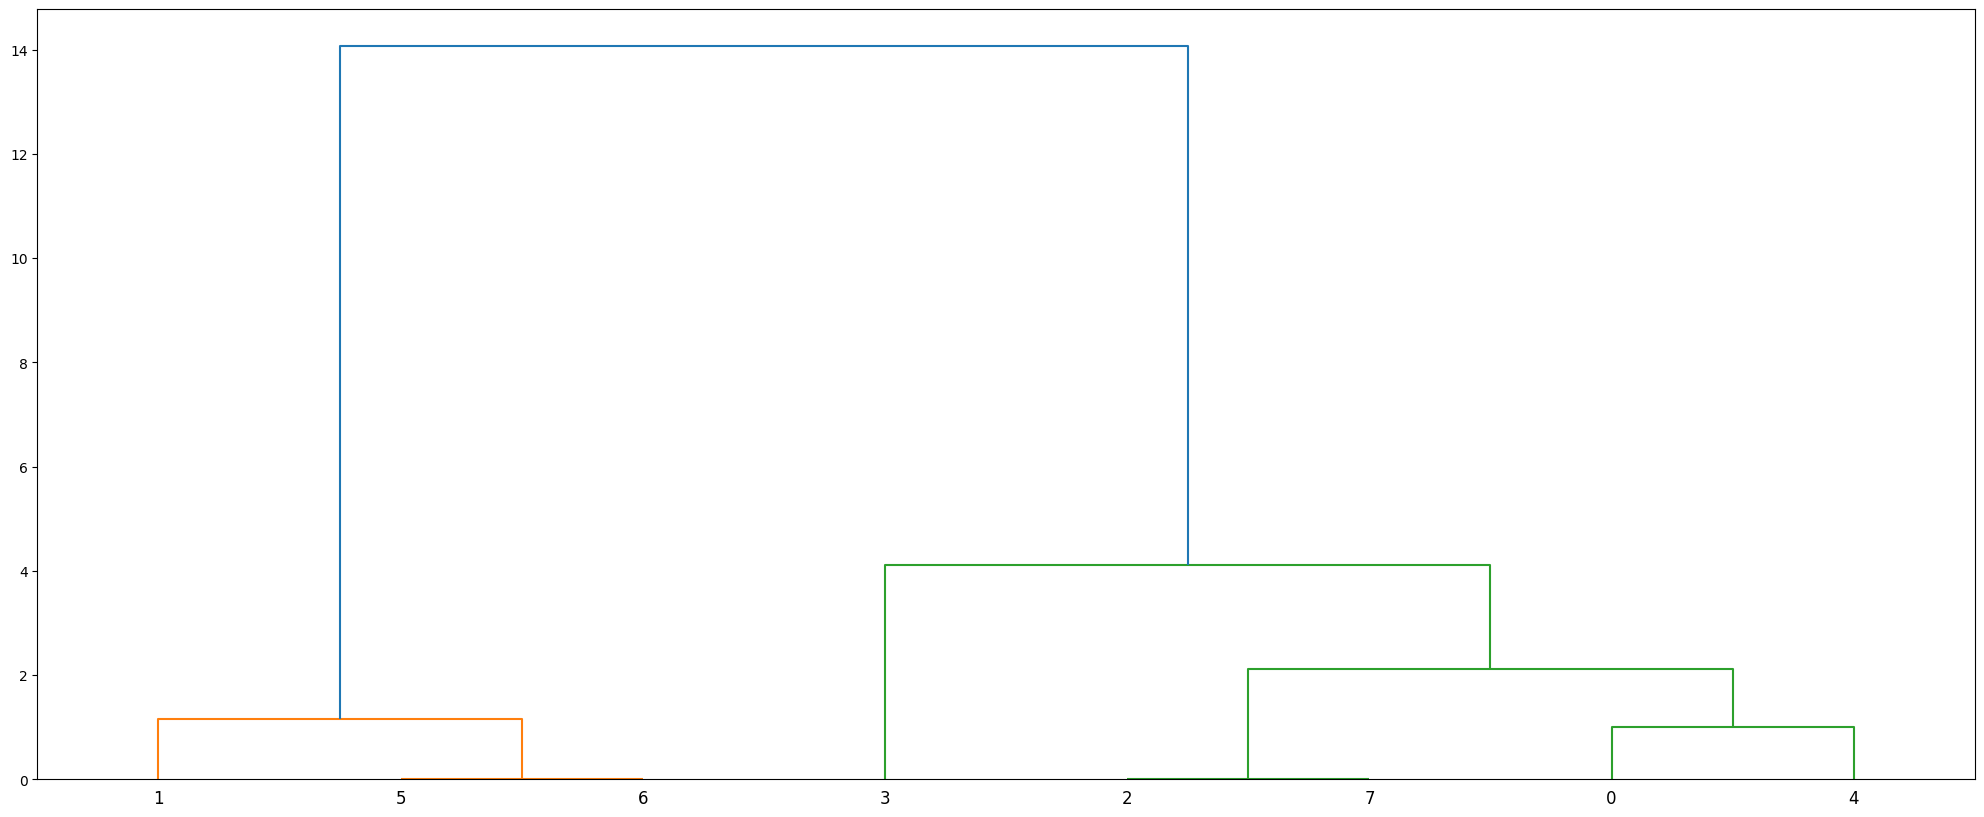

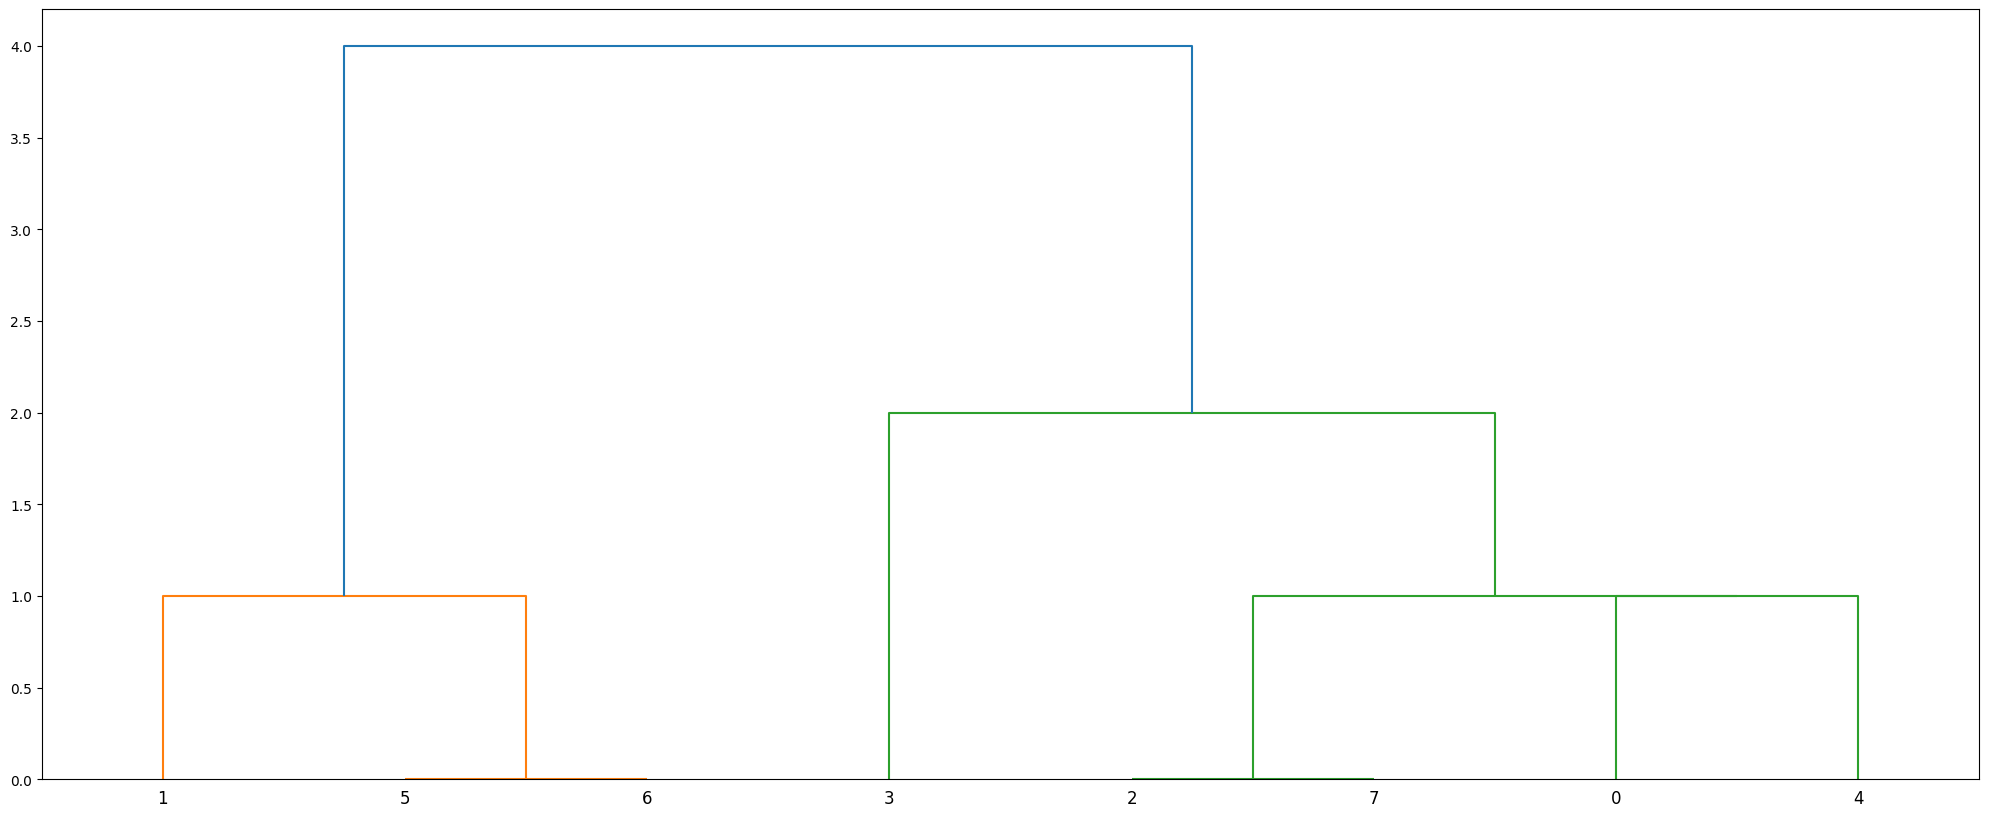

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]

Z = linkage(X, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

# Z = linkage(X, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
